In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=8)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.158:37160 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.158:37160,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
import cmocean
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'}, #originally mol/m^3
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [10]:
import glob
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/" + x

spinup_datafiles = sorted(glob.glob(datadir("CM4Xp125*spinup*")))
historical_datafiles = sorted(glob.glob(datadir("CM4Xp125*historical*")))
ssp585_datafiles = sorted(glob.glob(datadir("CM4Xp125_ssp585*")))
picontrol_datafiles = sorted(glob.glob(datadir("CM4Xp125*piControl*")))
picontrol_datafiles = sorted(list(set(picontrol_datafiles) - set(spinup_datafiles)))

expt_datafiles = {"forced": historical_datafiles + ssp585_datafiles, 
                  "control": picontrol_datafiles}

In [11]:
def _tracer_at_varmin(var_1d, tracer_1d):
    # temp_1d, salt_1d are 1D numpy arrays along depth
    if np.all(np.isnan(var_1d)):
        # no valid temperature → result should be NaN
        return np.nan
    # otherwise pick the index of the maximum temperature
    idx = np.nanargmin(var_1d)
    return tracer_1d[idx]

def get_tracer_at_varmin(ds: xr.Dataset, var: xr.Dataset): 
    return xr.apply_ufunc(
    _tracer_at_varmin,
    var,
    ds,
    input_core_dims=[["sigma2_l"], ["sigma2_l"]],
    output_core_dims=[[]],          # drop the 'depth' dim
    vectorize=True,                 # loop over (time,lat,lon)
    dask="parallelized",            # keep it lazy if you're on Dask arrays
    output_dtypes=[ds.dtype]
    )

def get_tracers_at_varmin(ds: xr.Dataset, var_name: str) -> xr.Dataset:
    """
    For a given driving variable `var_name`, find for each (time,lat,lon)
    the depth of its maximum and extract *all* other variables at that depth.
    
    Returns a new Dataset with one 3-D DataArray per tracer.
    """
    var = ds[var_name]
    out = {}
    for name, tracer in ds.data_vars.items():
        if name == var_name:
            continue
        out_name = f"{name}_at_{var_name}_max"
        out[out_name] = get_tracer_at_varmin(tracer, var)
        
        # xr.apply_ufunc(
        #     _tracer_at_varmax,
        #     var,
        #     tracer,
        #     input_core_dims=[["sigma2_l"], ["sigma2_l"]],
        #     output_core_dims=[[]],           # drop 'sigma2_l'
        #     vectorize=True,                  # loop over other dims
        #     dask="parallelized",             # keep it lazy
        #     output_dtypes=[tracer.dtype]
        # )
    return xr.Dataset(out)

In [22]:
tracersds = xr.open_mfdataset("/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_piControl_tracers_sigma2_0101-0105.zarr")
budgetds = xr.open_mfdataset("/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1750-1754.zarr")








/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [14]:
for key in expt_datafiles.keys():
    datafiles = expt_datafiles[key]
    ds_bottoms = []
    for (t, file) in enumerate(datafiles[0:2]): 
        print(key, ":", file)
        ds = xr.open_mfdataset(
            file,
            data_vars="minimal",
            coords="minimal",
            compat="override",
            parallel=True,
            engine="zarr")
        
        # ds["zos"] = 0
        
        # ds["z"] = approximate_z_top_down(ds, dim = "sigma2")
        # ds["z"] = ds["z"].where(ds["thkcello"] > 0)
        
        # ds["density"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
        # ds["density"] = ds["density"].where(ds["density"] > 0)
        # ds["density"].attrs["cell_methods"] = ds["thetao"].attrs["cell_methods"]

        # ds = ds.chunk({"sigma2_l":-1, "time":-1, "xh":20, "yh":20, })
        # # ds = ds.compute()

        # ds_bottom = get_tracers_at_varmin(ds.drop("zos"), "z") #drop zos, since it doesnt have dimensioms
        
    #     ds_bottoms += [1 * ds_bottom.compute()]

    # ds_bottoms_ts = xr.concat(ds_bottoms, dim = "time").sortby("time")
    # ds_za_ts["geolat"] = ds.geolat.mean("xh").compute()    
    
    # savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
    
    # savename = savedir + f"Glob_Zonal_Avg_Tracer_{key}.nc"
    # print(f"Saving {key} to", ": ", savename)
    # ds_za_ts.to_netcdf(savename)

forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1850-1854.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1855-1859.zarr
control : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_piControl_tracers_sigma2_0101-0105.zarr
control : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_piControl_tracers_sigma2_0106-0110.zarr


In [15]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:    (time: 60, sigma2_l: 74, yh: 224, xh: 240, yq: 225, xq: 241,
                sigma2_i: 75)
Coordinates: (12/26)
    areacello  (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    deptho     (yh, xh) float32 215kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    dxCv       (yq, xh) float64 432kB dask.array<chunksize=(225, 240), meta=np.ndarray>
    dyCu       (yh, xq) float64 432kB dask.array<chunksize=(224, 241), meta=np.ndarray>
    geolat     (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    geolat_c   (yq, xq) float64 434kB dask.array<chunksize=(225, 241), meta=np.ndarray>
    ...         ...
    wet_u      (yh, xq) float32 216kB dask.array<chunksize=(224, 241), meta=np.ndarray>
    wet_v      (yq, xh) float32 216kB dask.array<chunksize=(225, 240), meta=np.ndarray>
  * xh         (xh) int64 2kB 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
  * xq         (xq) int64 2kB 0 1 2 3 4 5 6 7 ... 234 235 236 237 238 239 240
  * yh         (yh) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
  * yq         (yq) int64 2kB 0 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
Data variables:
    agessc     (time, sigma2_l, yh, xh) float64 2GB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    cfc11      (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    cfc12      (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    sf6        (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    so         (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    thetao     (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
    thkcello   (time, sigma2_l, yh, xh) float32 955MB dask.array<chunksize=(1, 74, 224, 240), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 01060101.ocean_static.nc
    external_variables:  volcello areacello
    filename:            ocean_inert_z.010601-011012.cfc11.nc
    grid_tile:           N/A
    grid_type:           regular
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_piControl_c192_OM4p125_v8
    version:             v0.1.0

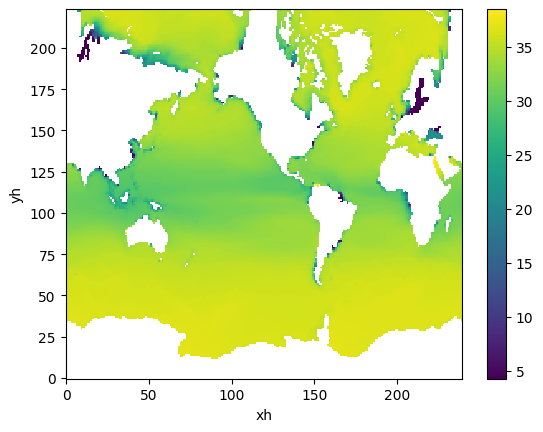

In [36]:
get_tracer_at_varmin(ds["density"], ds["z"]).mean("time").plot()

In [22]:
ds_compute["density"].isel(sigma2_l = ds_compute["z"].argmax(dim = "sigma2_l"))

ValueError: All-NaN slice encountered

In [11]:
ds_forced = xr.open_dataset(datadir("../Glob_Bottom_Tracer_forced.nc"))
ds_ctrl = xr.open_dataset(datadir("../Glob_Bottom_Tracer_control.nc"))
ds_ctrl.coords["time"] = ds_forced.time.values

Text(0.5, 1.0, 'Forced')

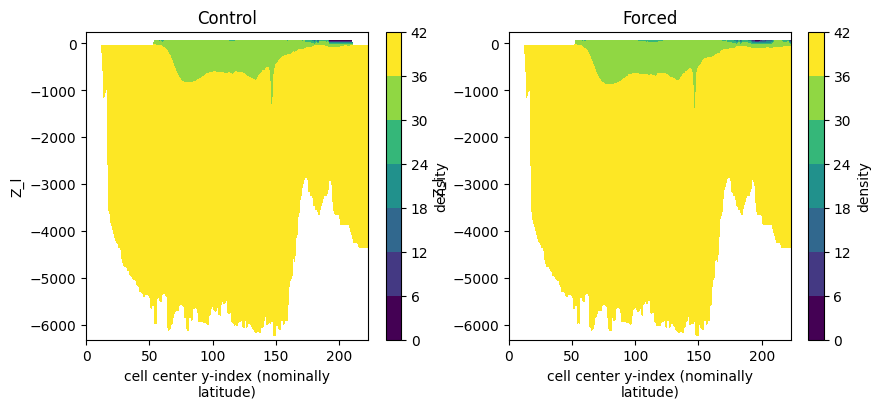

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").density.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").density.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")

Text(0.5, 1.0, 'Forced')

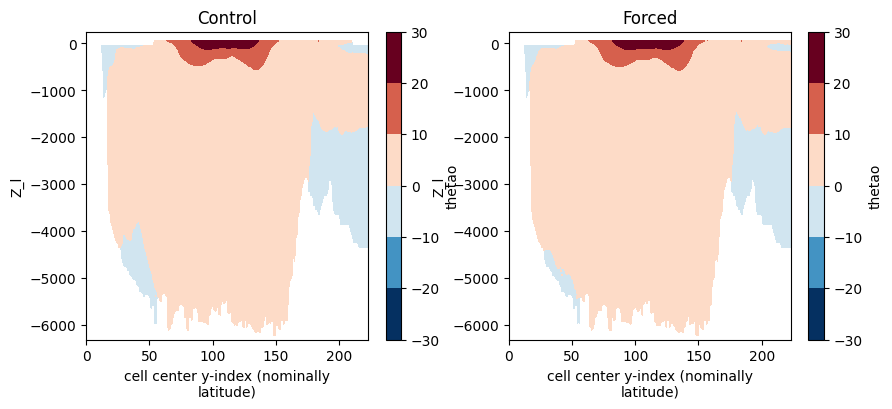

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").thetao.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").thetao.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")

Text(0.5, 1.0, 'Forced')

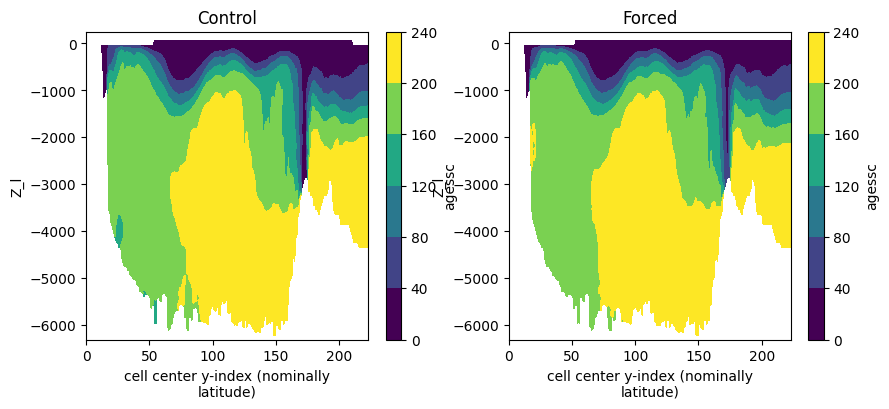

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").agessc.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").agessc.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")